In [112]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [113]:
import pandas as pd
from matplotlib.patches import Patch

In [114]:
df = pd.read_csv('./celltype_statistic.tsv',sep='\t')
df = df.set_index('BroadCelltypePathway')

info = pd.read_csv('../../compass/tokenizer/conception_processed.tsv',sep = '\t', index_col=0)
info = info[['BroadCelltypePathway', 'Concept_index', 'Lineage']].drop_duplicates().sort_values('Concept_index').set_index('BroadCelltypePathway').Lineage
lineage_colors = sns.palettes.color_palette('Set2', n_colors = len(info.unique()), desat=1).as_hex()
lineage_colors = [ '#a6d854', '#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
lineage_names = ['Lymphoid_lineage_Bcell', 'Lymphoid_lineage_T/NKcell','Myeloid_lineage', 'Mesenchymal_lineage', 'Functional_group']
lineage_color_map = dict(zip(lineage_names, lineage_colors))

df = df.loc[info.index]
df['lineage'] = df.index.map(info)
df['lineage_color'] = df.lineage.map(lineage_color_map)
df.index.name = 'Concept'
#df = df.reset_index()

In [115]:
lst = df.unique_genes.apply(lambda x:x.split(':')).tolist()
from itertools import chain
len(set(chain(*lst)))

916

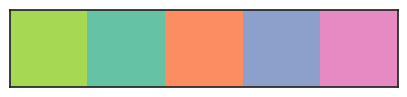

In [116]:
sns.palplot(lineage_color_map.values())

In [117]:
x_order =['Bcell_general', 'Memory_Bcell', 'Naive_Bcell', 'Plasma_cell',
       'CD4_Tcell', 'CD8_Tcell', 'Memory_Tcell', 'Naive_Tcell',
       'Tcell_general', 'Cytotoxic_Tcell', 'Exhausted_Tcell',
       'Immune_checkpoint', 'Treg', 'NKcell', 'Innate_lymphoid_cell', 'cDC',
       'pDC', 'Macrophage', 'Monocyte', 'Myeloid', 'Granulocyte', 'Mast',
       'Erythrocyte', 'Platelet', 'Stem', 'Stroma', 'Pericyte', 'Fibroblast',
       'Endothelial', 'Epithelial', 'Mesothelial', 'Adipocyte', 'Hepatocyte',
       'Pancreatic', 'Pneumocyte', 'Apoptosis_pathway', 'IFNg_pathway',
       'TGFb_pathway', 'Cytokine','TLS', 'Cell_proliferation', 
       'Genome_integrity', 'Reference']
df = df.loc[x_order]

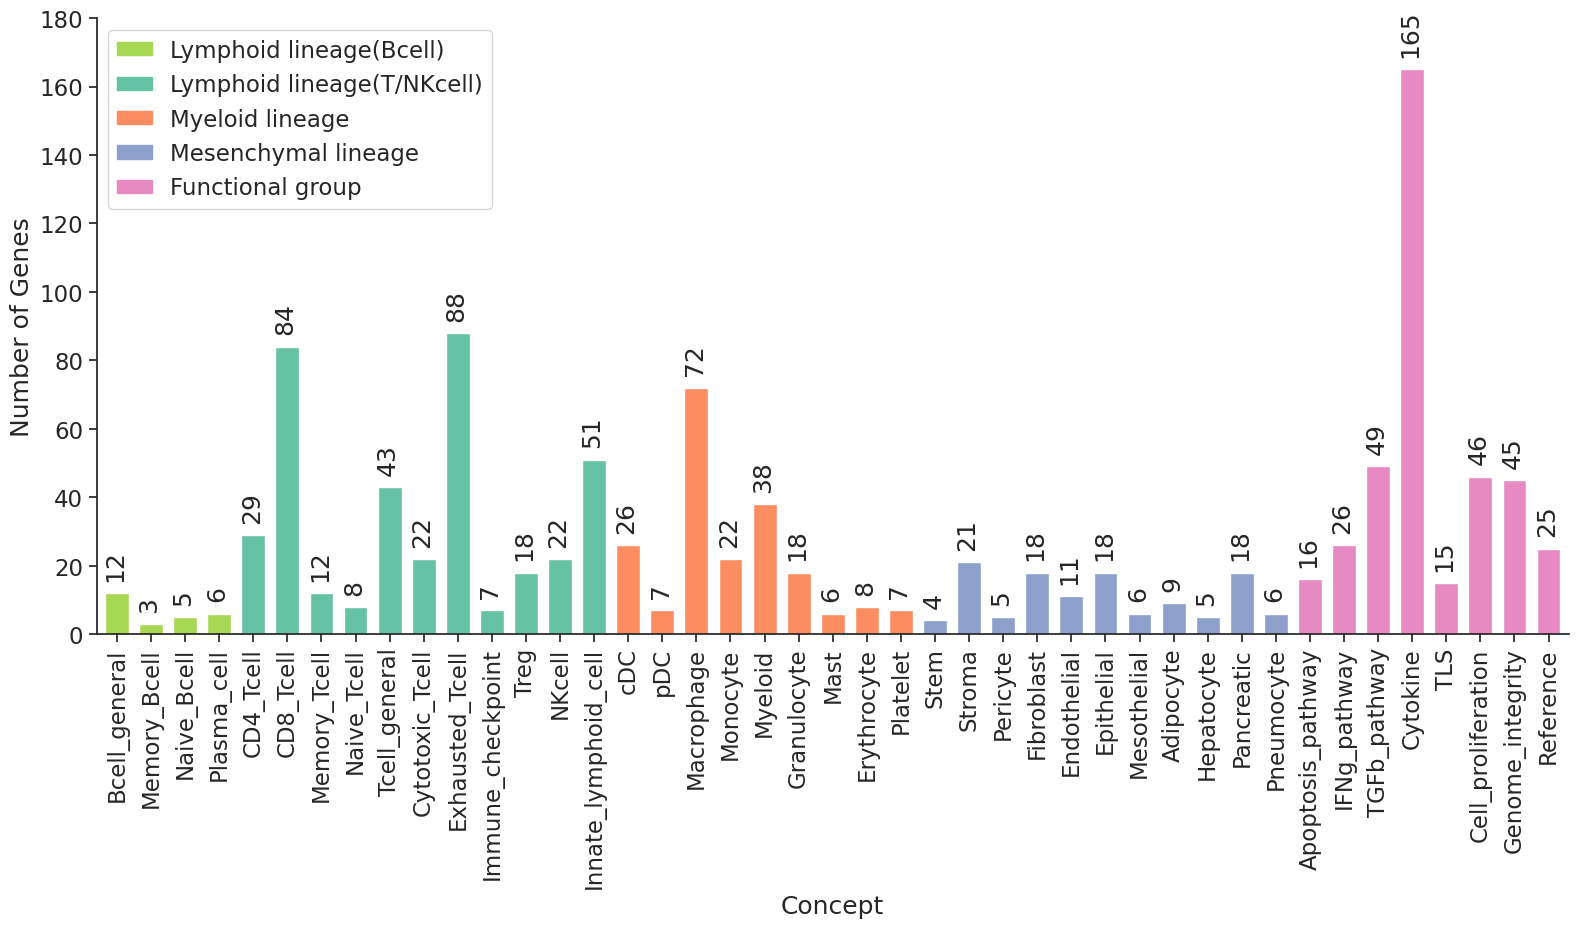

In [118]:
fig, ax = plt.subplots(figsize = (19,8))

y = 'total_num_unique_genes'
df[y].plot(kind='bar', ax=ax, width = 0.7, color = df.lineage_color)

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(df.index, 
                    rotation=90,  #ha="right",rotation_mode="anchor"
                  )  # <====== HERE is the ke
ax.set_ylabel('Number of Genes')

for i in range(len(df)):
    ts = df.iloc[i]
    ax.text(i-0.4, ts[y]+5, str(ts[y]), rotation = 90)

ax.set_ylim(0, 180)
ax.set_xlabel('Concept')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Add the legend to the plot
lg = {'Lymphoid lineage(Bcell)': '#a6d854',
 'Lymphoid lineage(T/NKcell)': '#66c2a5',
 'Myeloid lineage': '#fc8d62',
 'Mesenchymal lineage': '#8da0cb',
 'Functional group': '#e78ac3'}
legend_patches = [Patch(color=color, label=label.replace('_', ' ')) for label, color in lg.items()]
plt.legend(handles=legend_patches, title=None, loc='best', handlelength=1.5, handleheight=0.5,) #bbox_to_anchor=(1.05, 1), 

fig.savefig('concept_gene_num.svg', bbox_inches="tight")

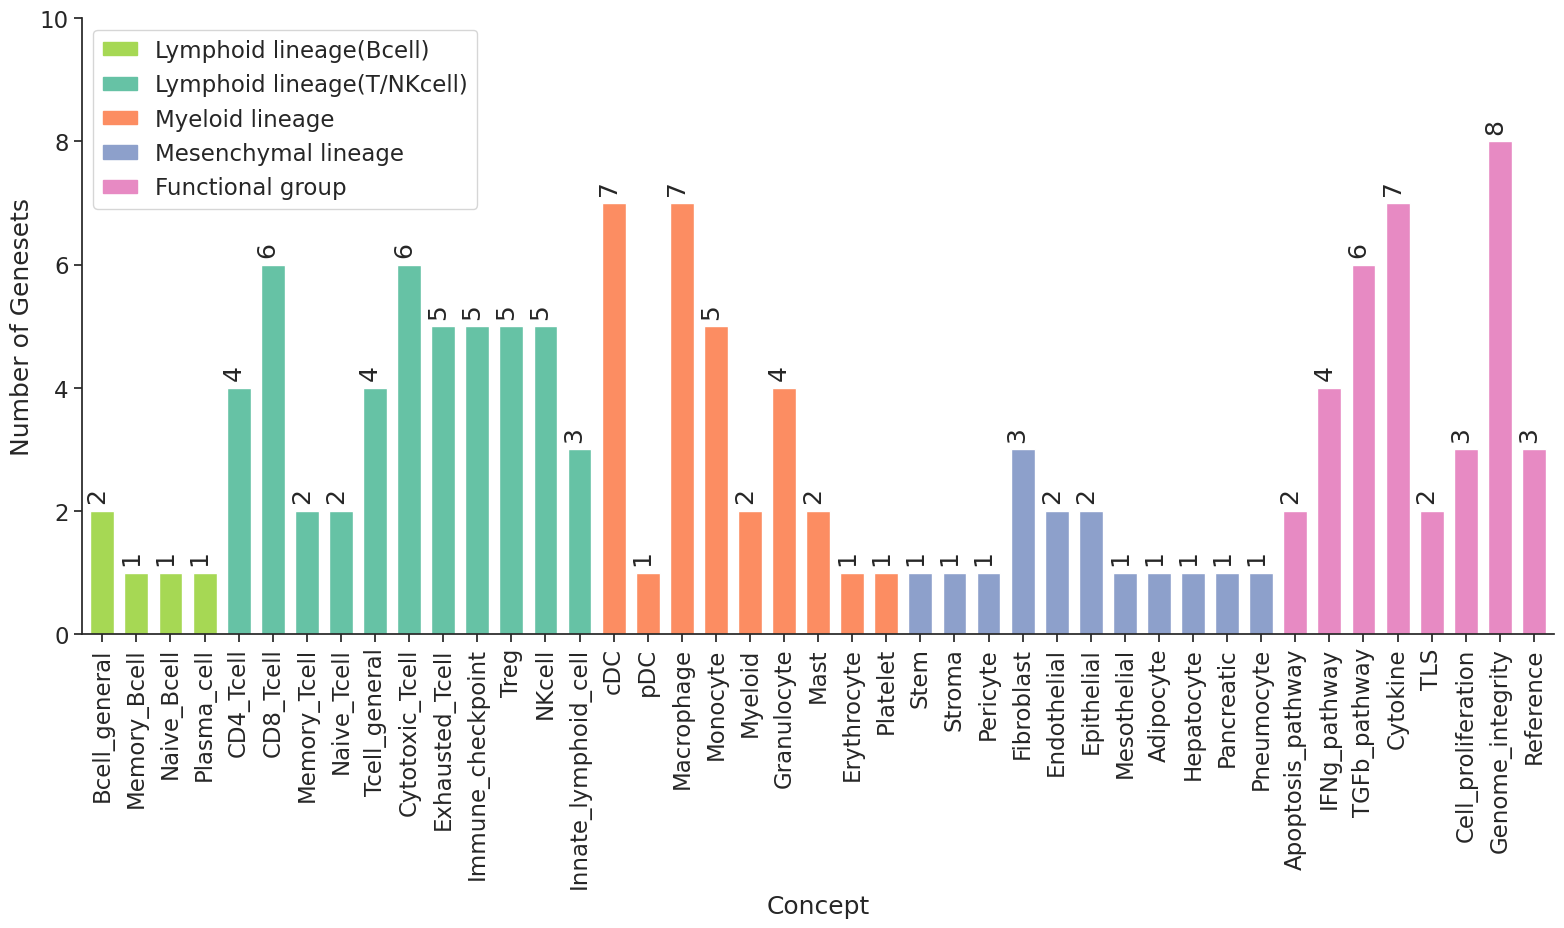

In [119]:
fig, ax = plt.subplots(figsize = (19,8))
y = 'num_genesets'

df[y].plot(kind='bar', ax=ax, width=0.7, color = df.lineage_color)

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(df.index, 
                    rotation=90, 
                    #ha="right",  rotation_mode="anchor"
                    )  # <====== HERE is the ke
ax.set_ylabel('Number of Genesets')

for i in range(len(df)):
    ts = df.iloc[i]
    ax.text(i-0.5, ts[y]+0.2, str(ts[y]), rotation = 90)

ax.set_ylim(0, 10)
ax.set_xlabel('Concept')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

lg = {'Lymphoid lineage(Bcell)': '#a6d854',
 'Lymphoid lineage(T/NKcell)': '#66c2a5',
 'Myeloid lineage': '#fc8d62',
 'Mesenchymal lineage': '#8da0cb',
 'Functional group': '#e78ac3'}
legend_patches = [Patch(color=color, label=label.replace('_', ' ')) for label, color in lg.items()]
plt.legend(handles=legend_patches, title=None, loc='best', handlelength=1.5, handleheight=0.5,) #bbox_to_anchor=(1.05, 1), 


fig.savefig('concept_geneset_num.svg', bbox_inches="tight")

In [120]:
def compute_jaccard_index(set1, set2):
    set1 = set(set1)
    set2 = set(set2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if union else 0

def compute_jaccard_matrix(cell_types_series):
    cell_types = cell_types_series.index
    jaccard_matrix = pd.DataFrame(index=cell_types, columns=cell_types, dtype=float)

    for i, ct1 in enumerate(cell_types):
        for j, ct2 in enumerate(cell_types):
            if i <= j:  # 避免重复计算
                jaccard_index = compute_jaccard_index(set(cell_types_series[ct1]), set(cell_types_series[ct2]))
                jaccard_matrix.at[ct1, ct2] = jaccard_index
                jaccard_matrix.at[ct2, ct1] = jaccard_index

    return jaccard_matrix

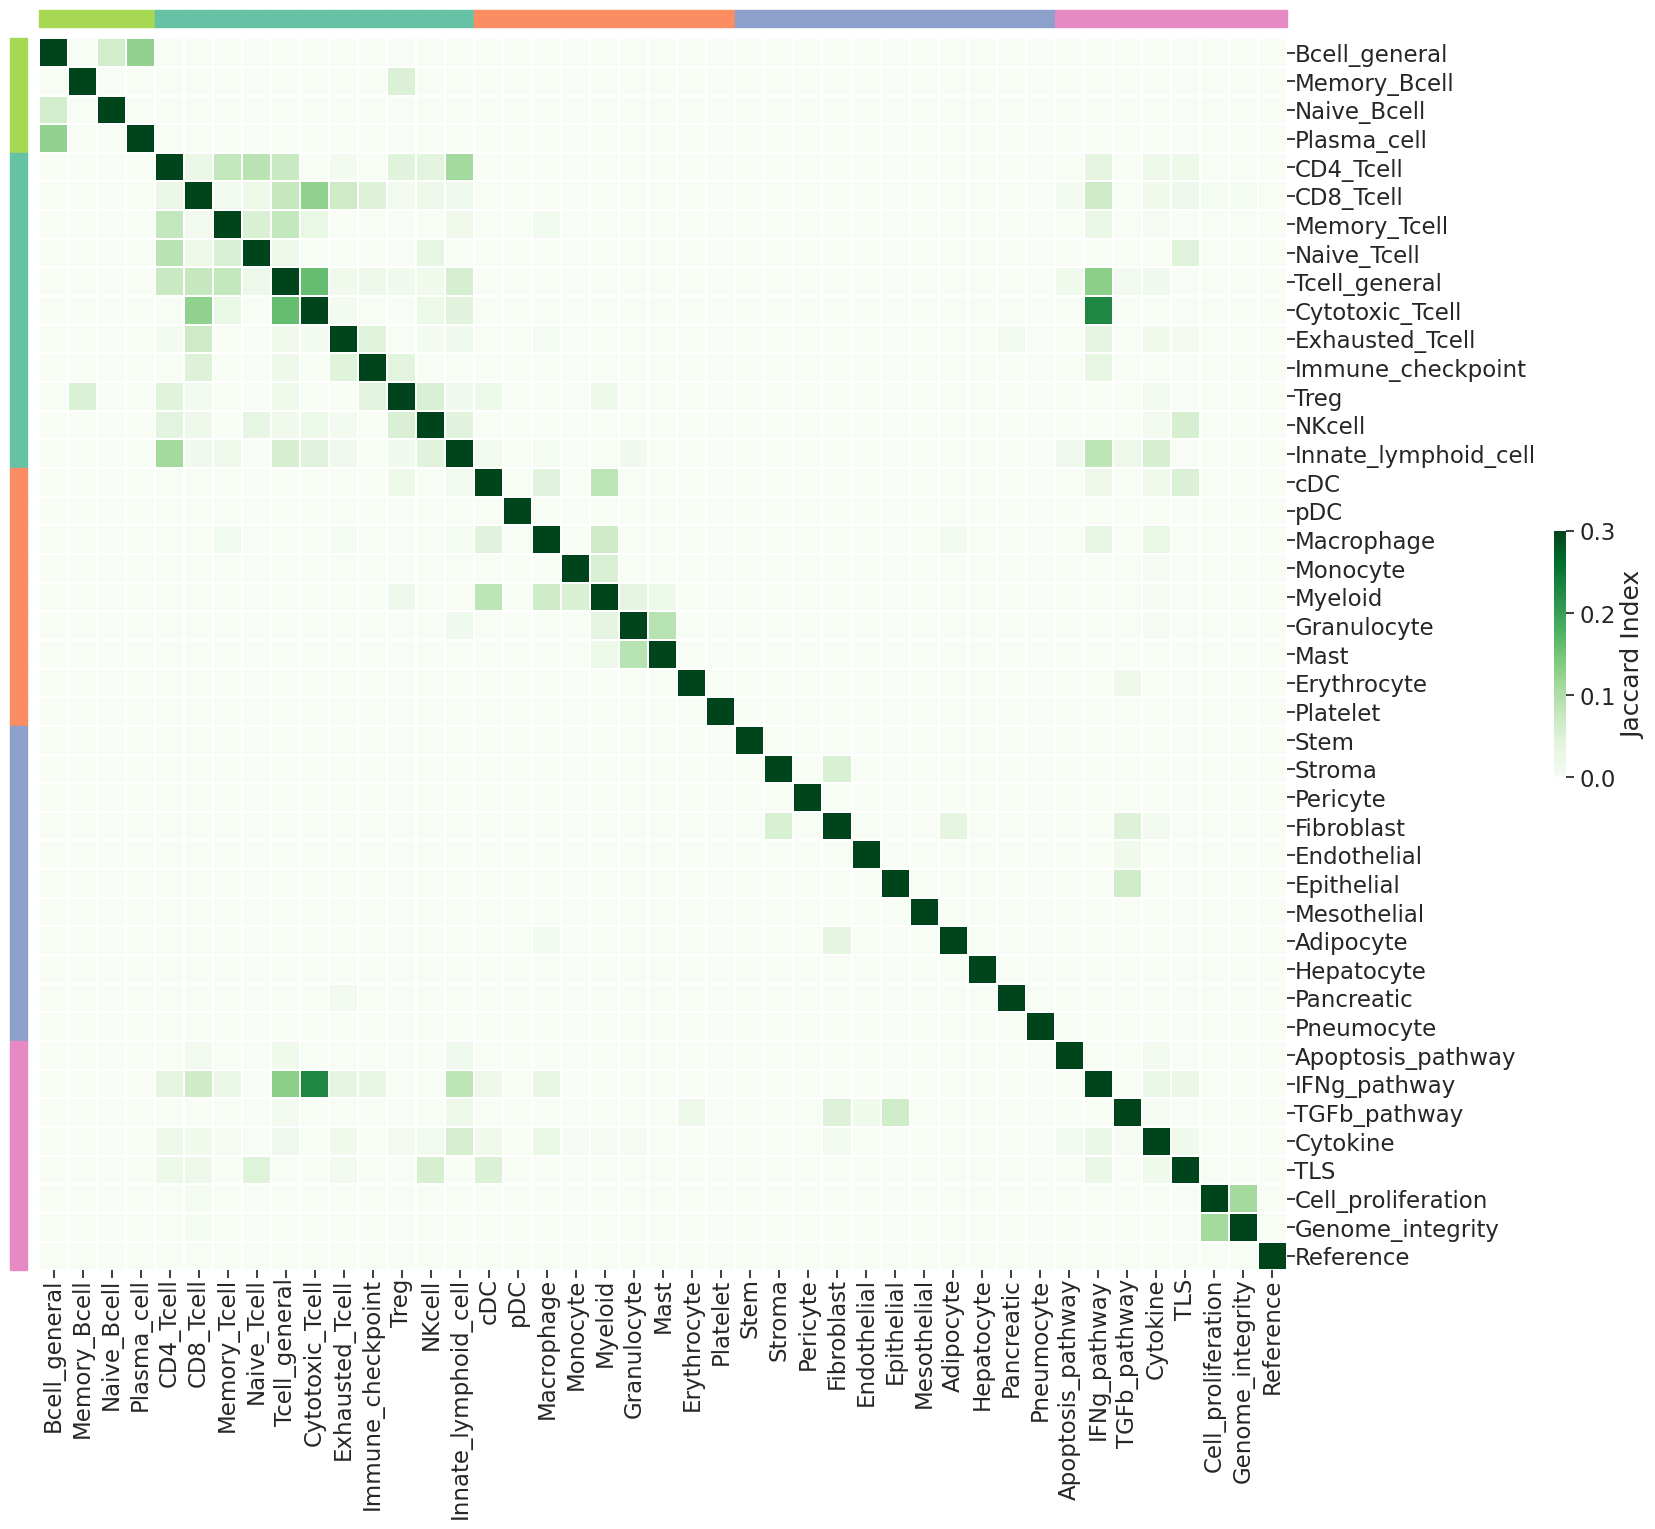

In [121]:
celltype_genes = df['unique_genes'].apply(lambda x:x.split(':'))

datap = compute_jaccard_matrix(celltype_genes)
datap.columns.name = None
datap.index.name = None


datap = datap[x_order].loc[x_order]



fig, ax = plt.subplots(figsize=(23, 16))
g = sns.heatmap(datap,  cmap="Greens",  #annot=True, dendrogram_ratio=0.1, 
                   vmax=0.3, #tree_kws={'lengths': 2},cbar_pos=(1, .8, .01, .15),
                    cbar_kws = {'label':"Jaccard Index", 'shrink':0.2, 'pad':0.15},
                   linewidths=.01, ax=ax)

ax.yaxis.tick_right()  # 将y轴刻度标签移到右侧
ax.yaxis.set_label_position('right')  # 将y轴标签移到右侧
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, )  # 设置标签垂直对齐


ax.tick_params( bottom='off',  labelbottom = 'on',  pad=-.5)

# g.savefig('concept_jaccard_sim.jpg')
# g.savefig('concept_jaccard_sim.svg')


for idx, color in enumerate(df.lineage_color):
    ax.add_patch(plt.Rectangle((idx, -1), 1, 0.6, color=color, transform=ax.transData, clip_on=False))
    ax.add_patch(plt.Rectangle((-1, idx), 0.6, 1, color=color, transform=ax.transData, clip_on=False))
fig.savefig('concept_jaccard_index.svg', bbox_inches="tight")

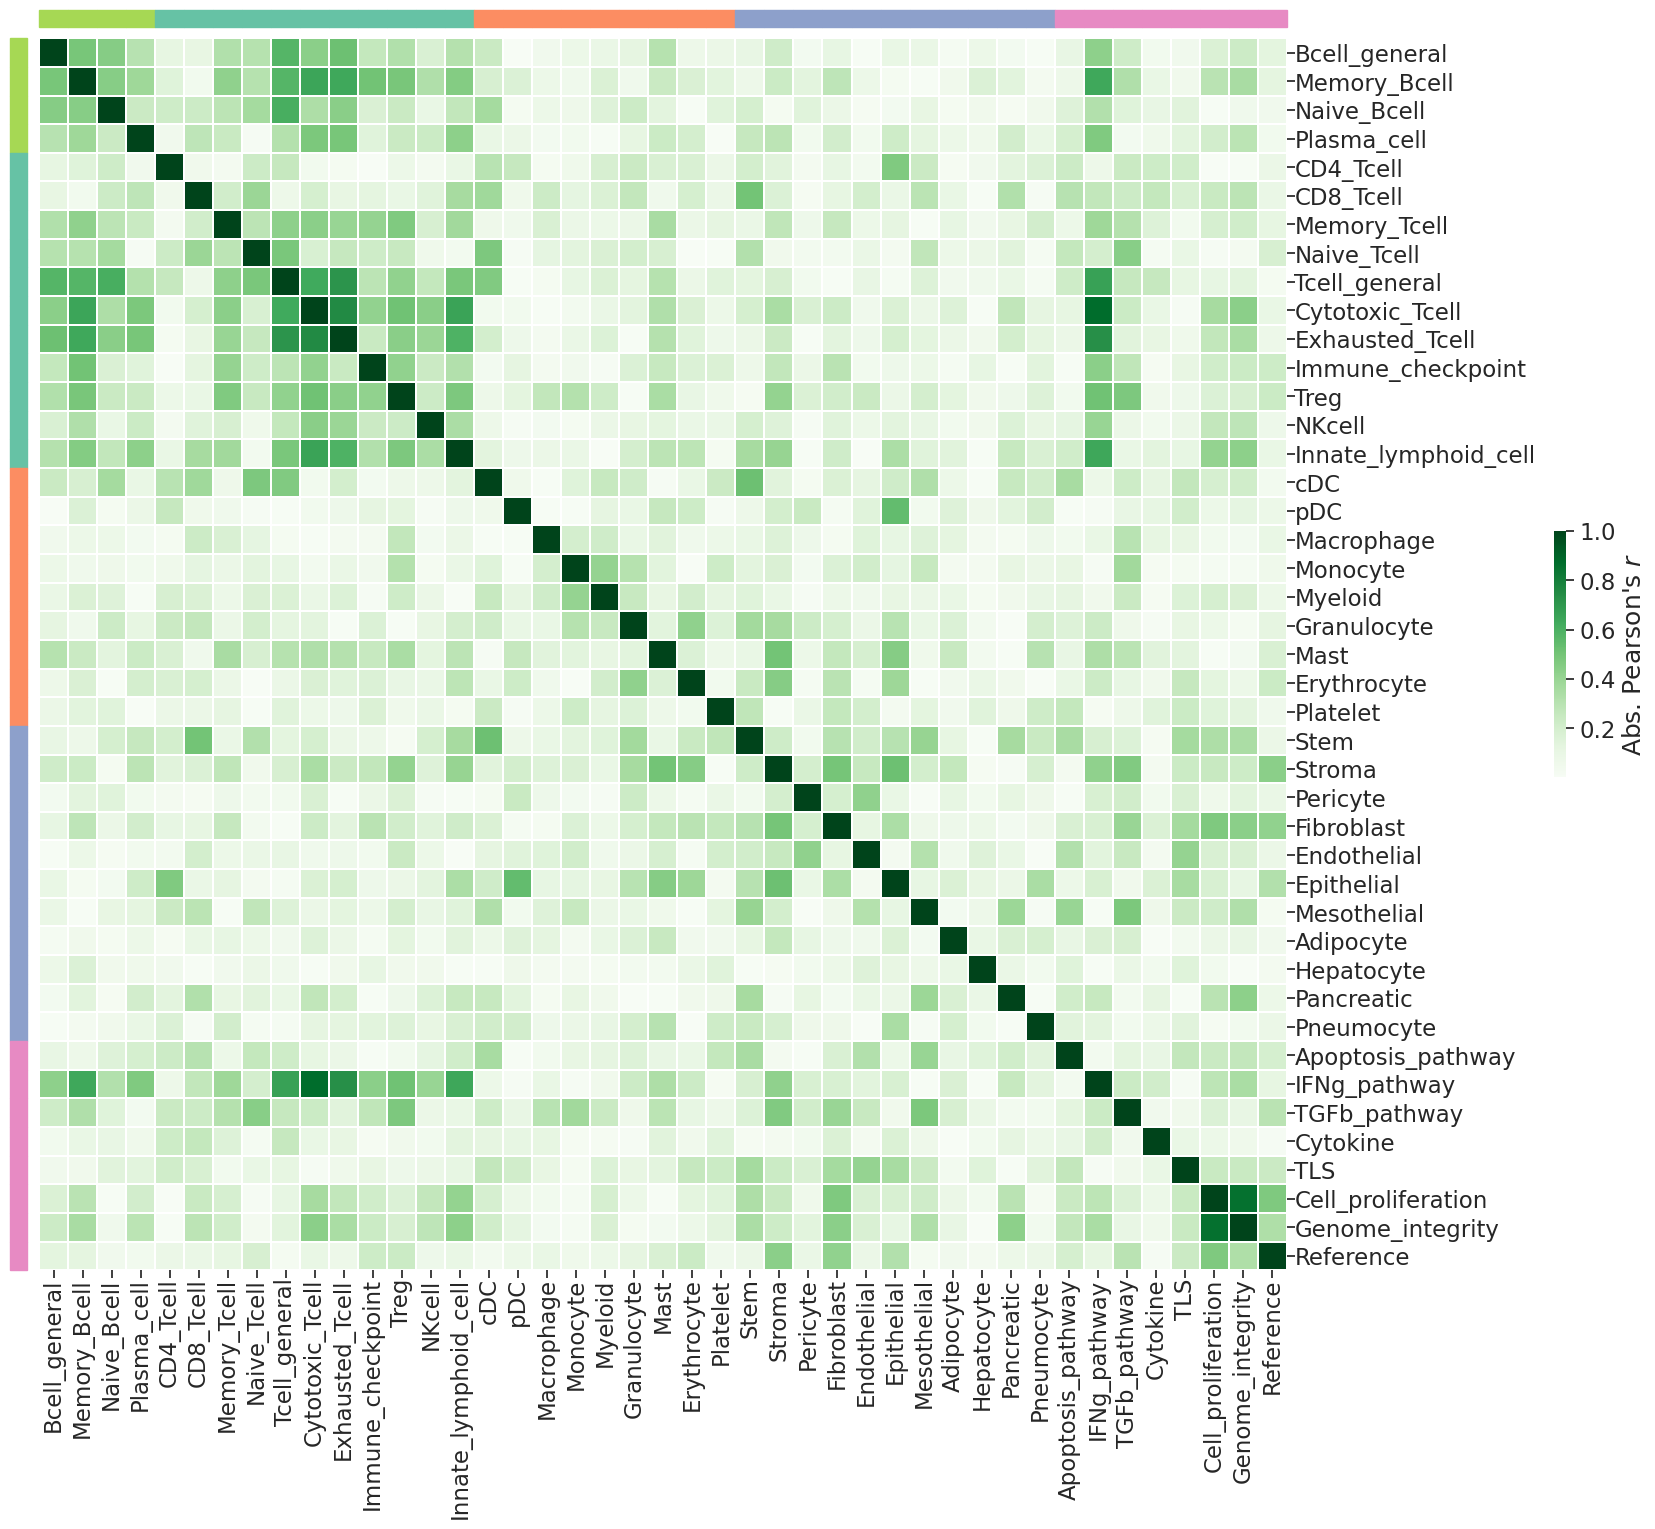

In [122]:
dfcs = pd.read_csv('../01_extract_readout/TCGA/02_readouts_celltype.csv', index_col=0)

dfcs = dfcs[dfcs.columns.difference(['CANCER'])]
data_corr = dfcs.corr('pearson').abs()
data_corr.columns.name = 'Concepts'
data_corr.index.name = 'Concepts'


dfcs = dfcs[dfcs.columns.difference(['CANCER'])]
data_corr = dfcs.corr().abs()
data_corr.columns.name = None
data_corr.index.name = None



datap = data_corr[x_order].loc[x_order]

fig, ax = plt.subplots(figsize=(23, 16))
g = sns.heatmap(datap,  cmap="Greens",  #annot=True, dendrogram_ratio=0.1, 
                   vmax=1, #tree_kws={'lengths': 2},cbar_pos=(1, .8, .01, .15),
                    cbar_kws = {'label':"Abs. Pearson's $r$", 'shrink':0.2, 'pad':0.15},
                   linewidths=.1,  ax=ax)

ax.yaxis.tick_right()  # 将y轴刻度标签移到右侧
ax.yaxis.set_label_position('right')  # 将y轴标签移到右侧
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, )  # 设置标签垂直对齐


ax.tick_params( bottom='off',  labelbottom = 'on',  pad=-.5)

# g.savefig('concept_jaccard_sim.jpg')
# g.savefig('concept_jaccard_sim.svg')


for idx, color in enumerate(df.lineage_color):
    ax.add_patch(plt.Rectangle((idx, -1), 1, 0.6, color=color, transform=ax.transData, clip_on=False))
    ax.add_patch(plt.Rectangle((-1, idx), 0.6, 1, color=color, transform=ax.transData, clip_on=False))

fig.savefig('concept_pearson_sim.svg', bbox_inches="tight")

/tmp/ipykernel_52792/814045025.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


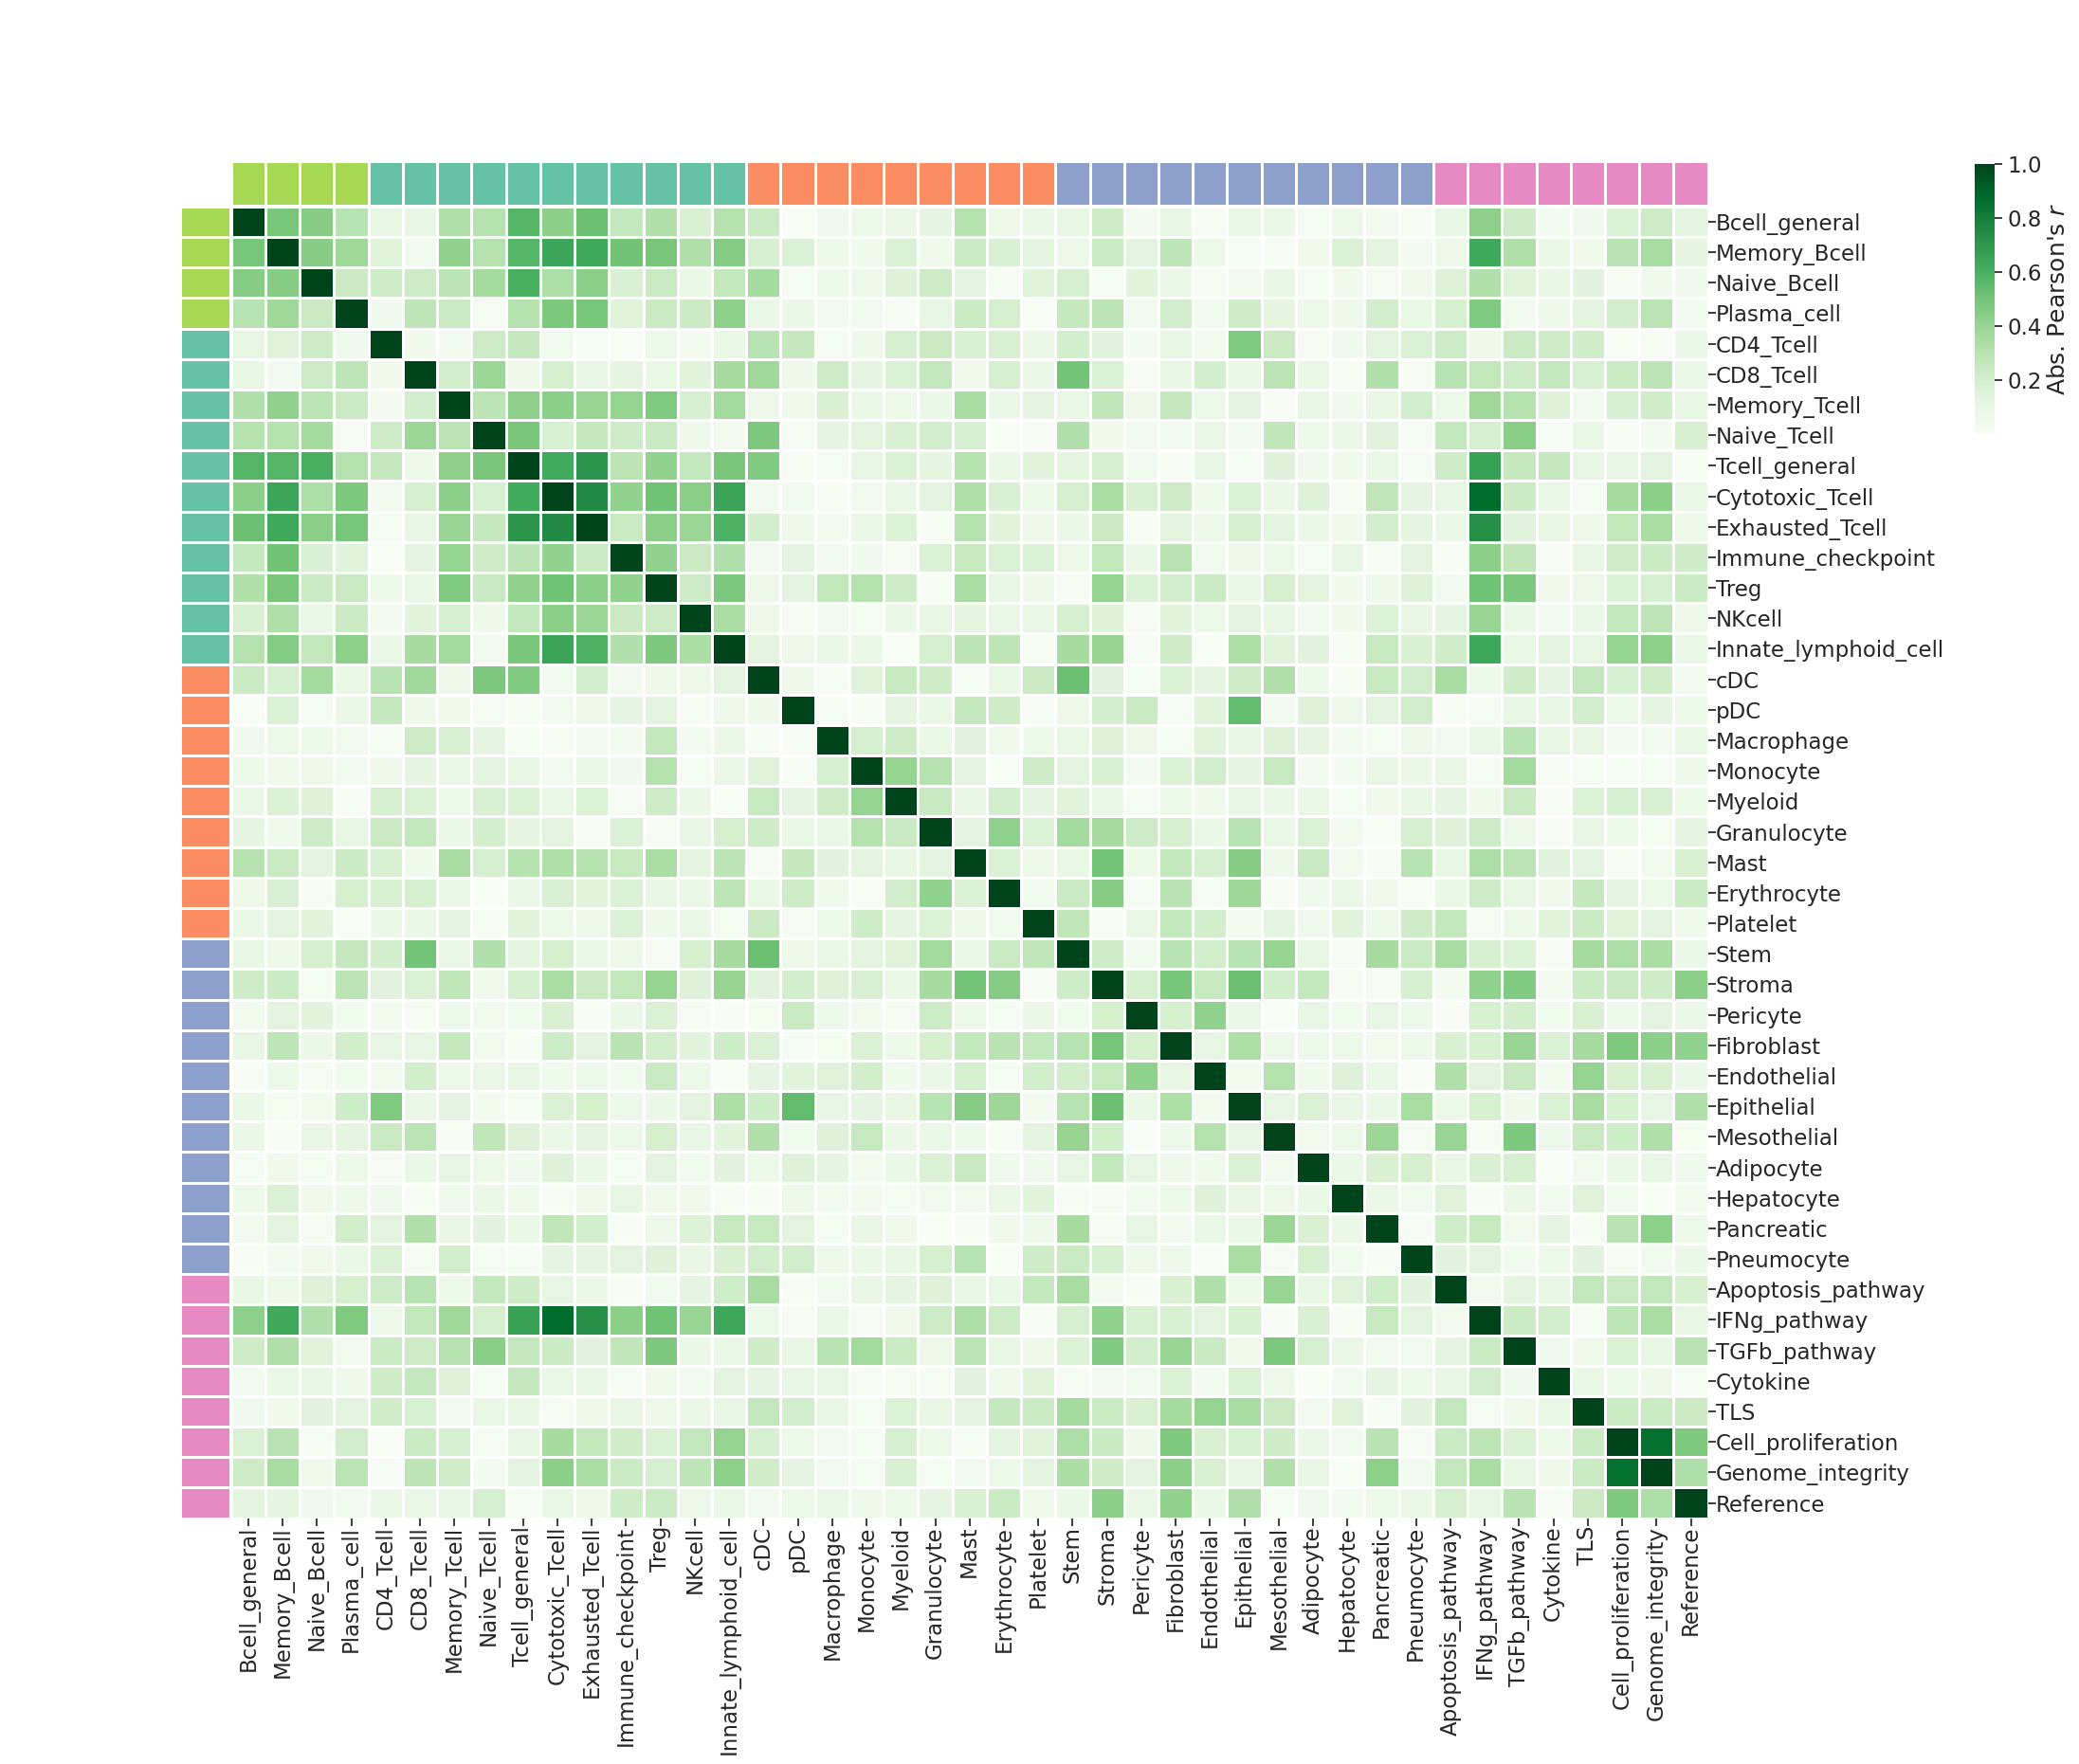

In [123]:
g = sns.clustermap(datap,  cmap="Greens",    row_cluster=False,col_cluster=False, 
                   row_colors = df.lineage_color.tolist(),
                   col_colors = df.lineage_color.tolist(),
                   dendrogram_ratio=0.1, vmax=1, #tree_kws={'lengths': 2},
                    cbar_kws =  {'label':"Abs. Pearson's $r$", 'shrink':0.2, 'pad':0.01}, 
                   
                   cbar_pos=(1., .75, .01, .15),
                   
                   linewidths=.75, figsize=(21, 19))

g.ax_heatmap.tick_params(bottom='off', labelbottom = 'on',  pad=-.1)

g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)
plt.tight_layout()




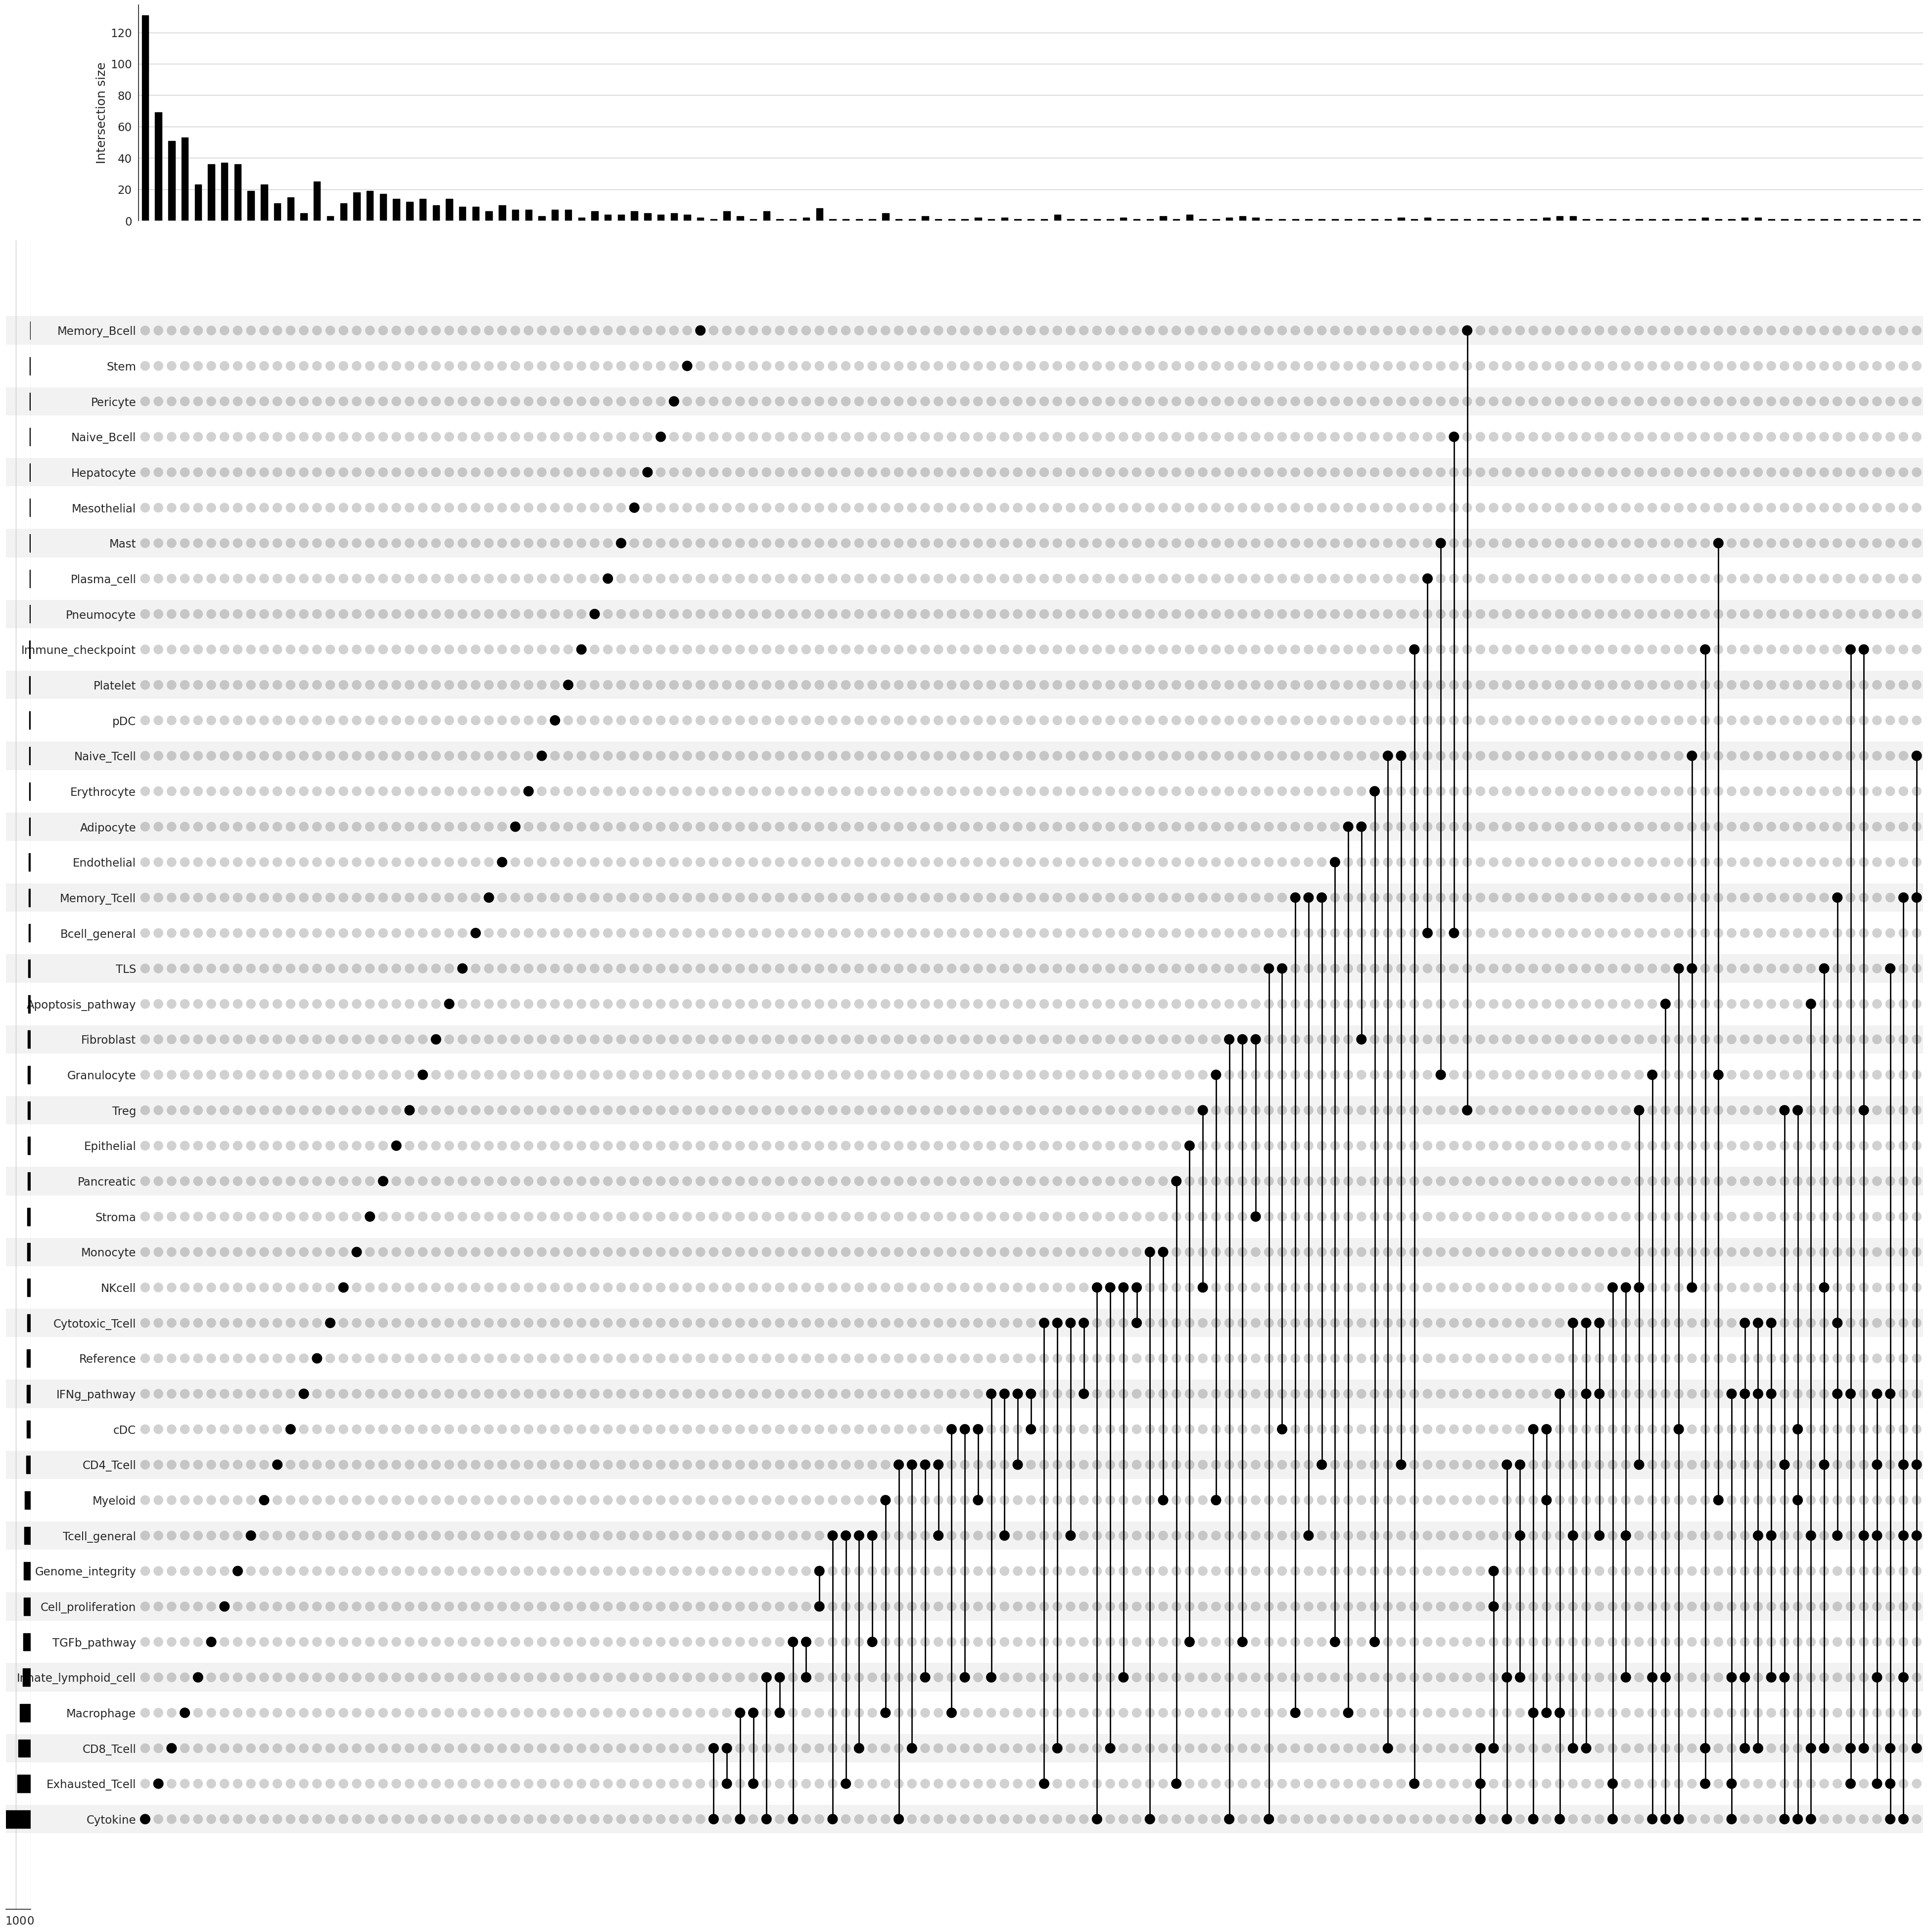

In [124]:
from itertools import chain

from matplotlib import pyplot as plt
from upsetplot import UpSet, plot


cols = celltype_genes.index #['TMB', 'PLFcell']

s = celltype_genes.loc[cols]
gs = list(set(chain(*s.values)))
results = []
for k, v in s.items():
    res = []
    for i in gs:
        if i in v:
            res.append(1)
        else:
            res.append(0)
    results.append(res)
df = pd.DataFrame(results, index = s.index, columns=gs).T
data = df.groupby(list(cols)).size()


fig = plt.figure(figsize=(50, 50))
plot(data, fig=fig,  element_size=None,)
fig.savefig('concept_upset.pdf')

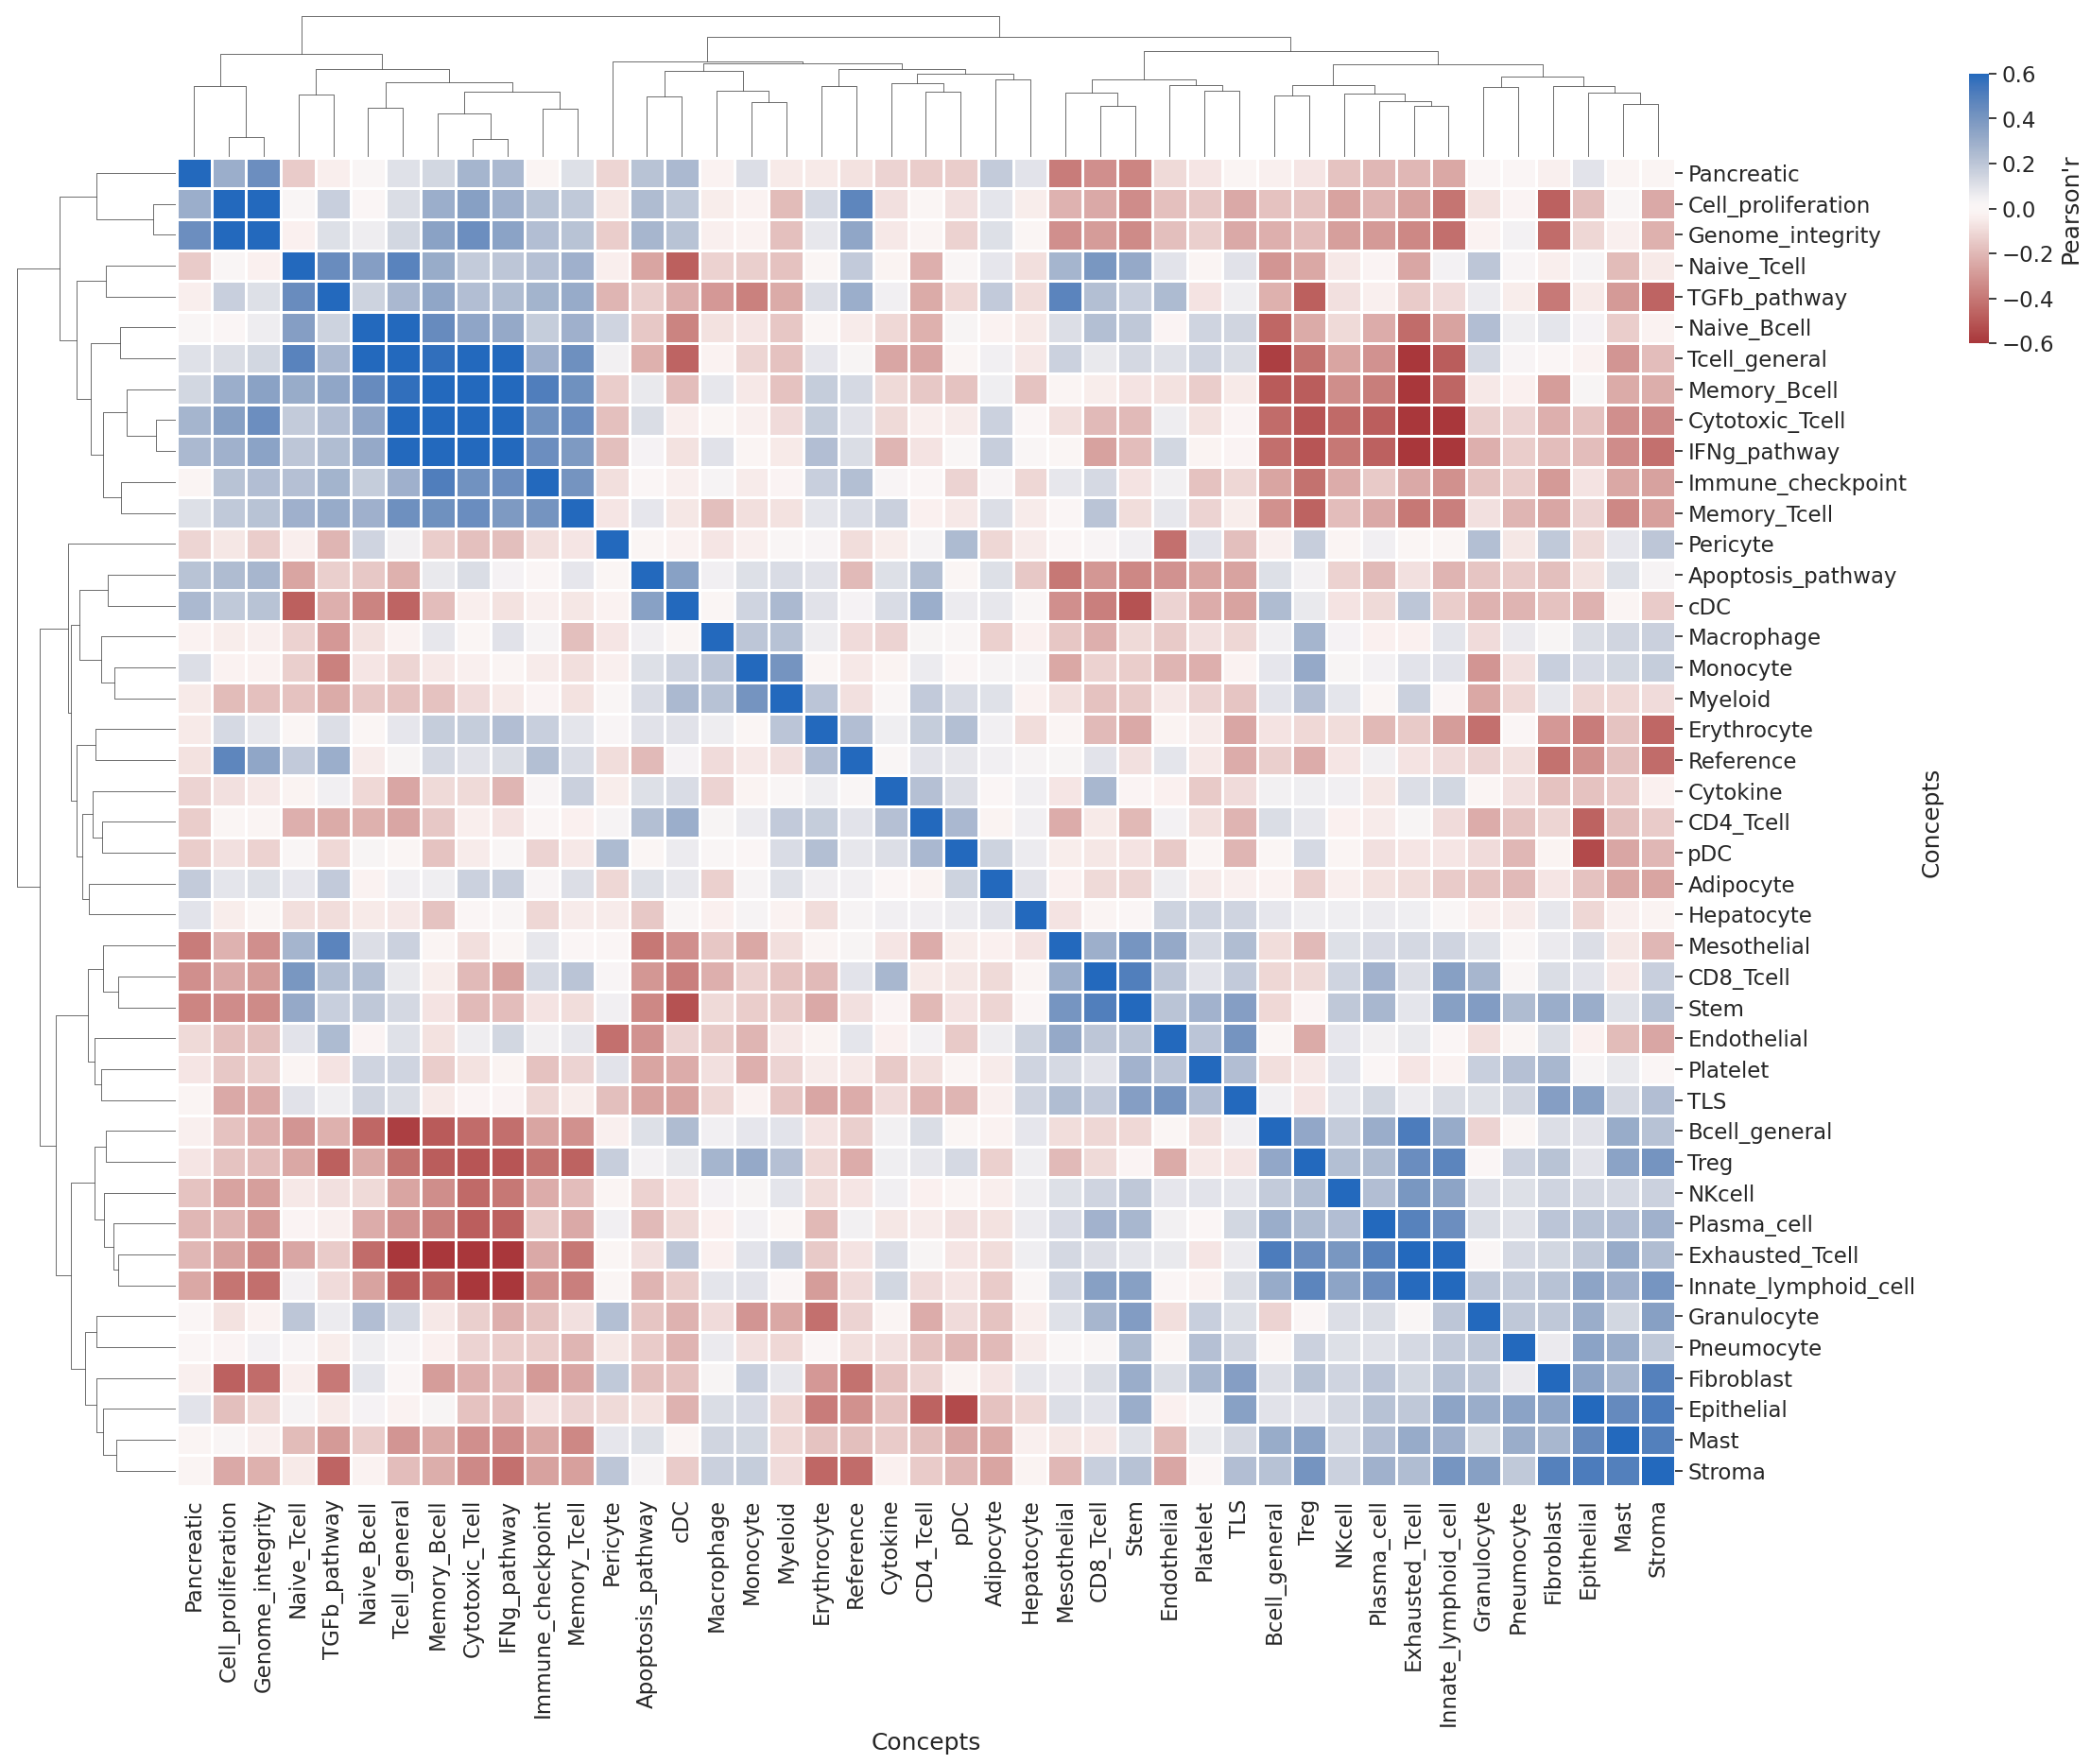

In [125]:
dfcs = pd.read_csv('../01_extract_readout/TCGA/02_readouts_celltype.csv', index_col=0)
dfcs = dfcs[dfcs.columns.difference(['CANCER'])]
data_corr = dfcs.corr()
data_corr.columns.name = 'Concepts'
data_corr.index.name = 'Concepts'
g = sns.clustermap(data_corr,   center=0, cmap="vlag_r",
                   dendrogram_ratio=0.1,  vmin=-0.6, vmax=0.6,
                   cbar_pos=(1, .8, .01, .15), cbar_kws = {'label':"Pearson'r"},
                   linewidths=.75, figsize=(21, 19))

#g.savefig('concept_score_sim.jpg')

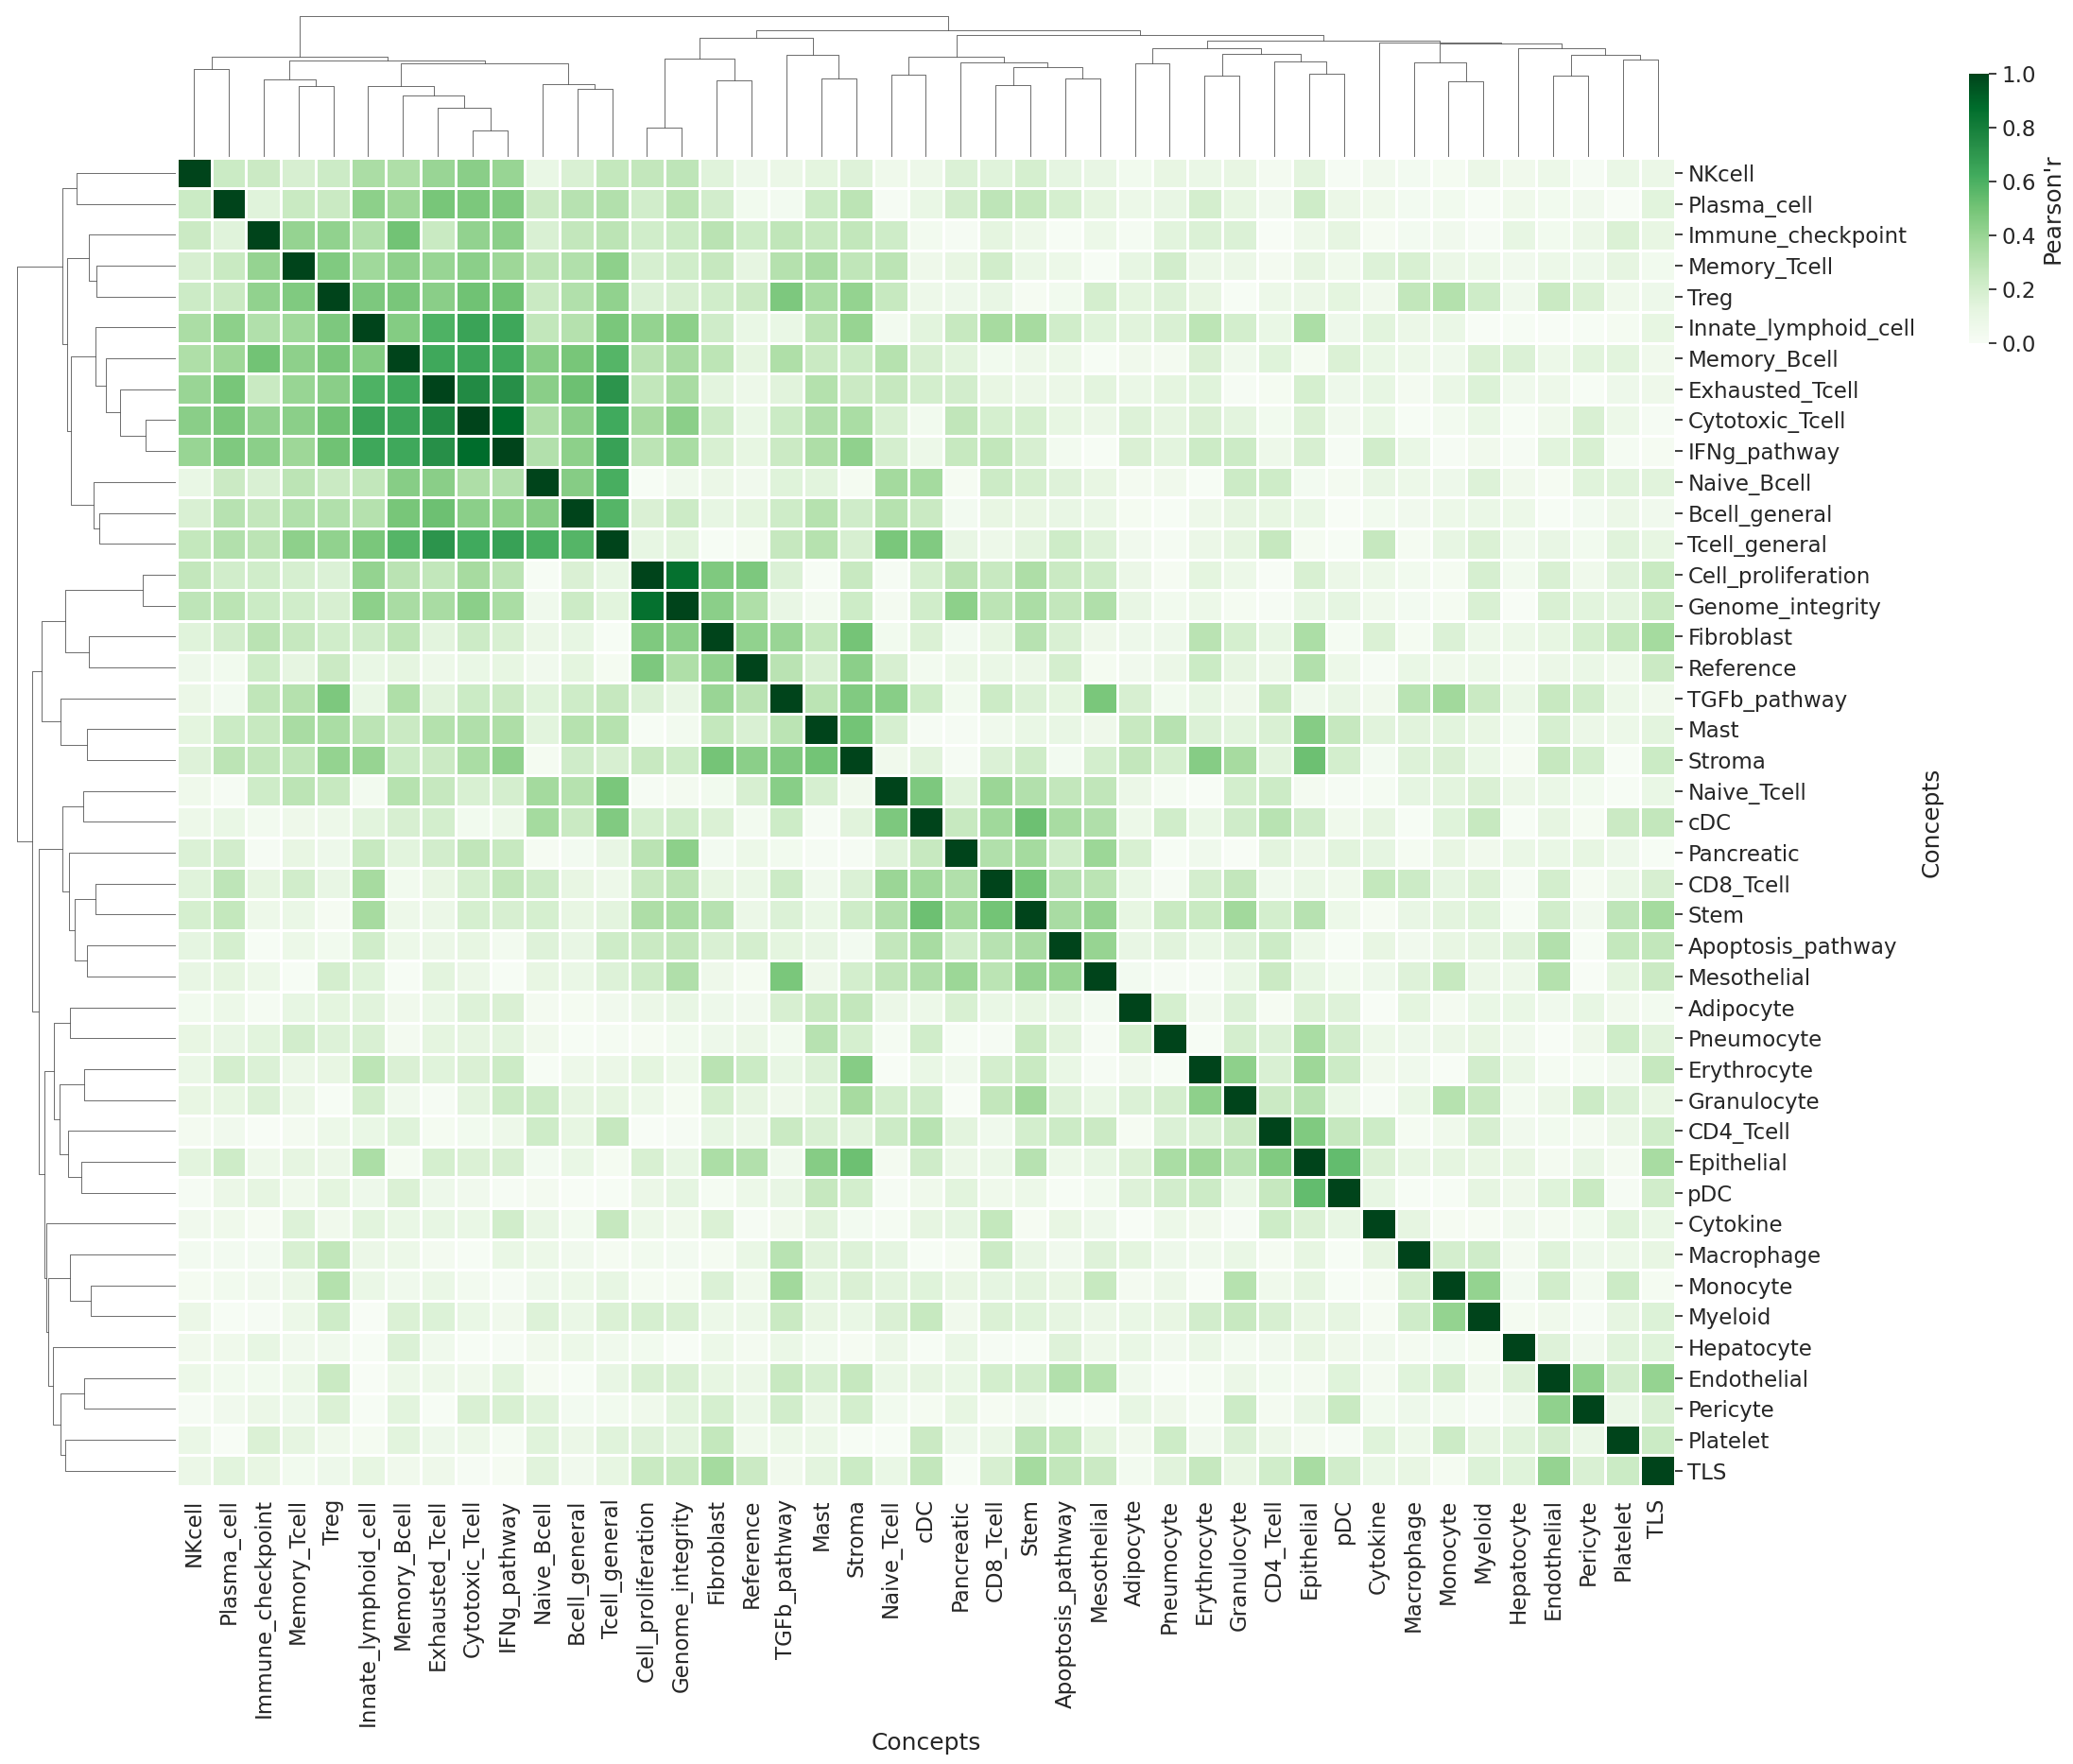

In [126]:
dfcs = pd.read_csv('../01_extract_readout/TCGA/02_readouts_celltype.csv', index_col=0)
dfcs = dfcs[dfcs.columns.difference(['CANCER'])]
data_corr = dfcs.corr().abs()
data_corr.columns.name = 'Concepts'
data_corr.index.name = 'Concepts'
g = sns.clustermap(data_corr,   cmap="Greens",
                   dendrogram_ratio=0.1,  vmin=0, vmax=1,
                   cbar_pos=(1, .8, .01, .15), cbar_kws = {'label':"Pearson'r"},
                   linewidths=.75, figsize=(21, 19))

# g.savefig('tcga_concept_score_sim2.jpg')
# g.savefig('tcga_concept_score_sim2.svg')

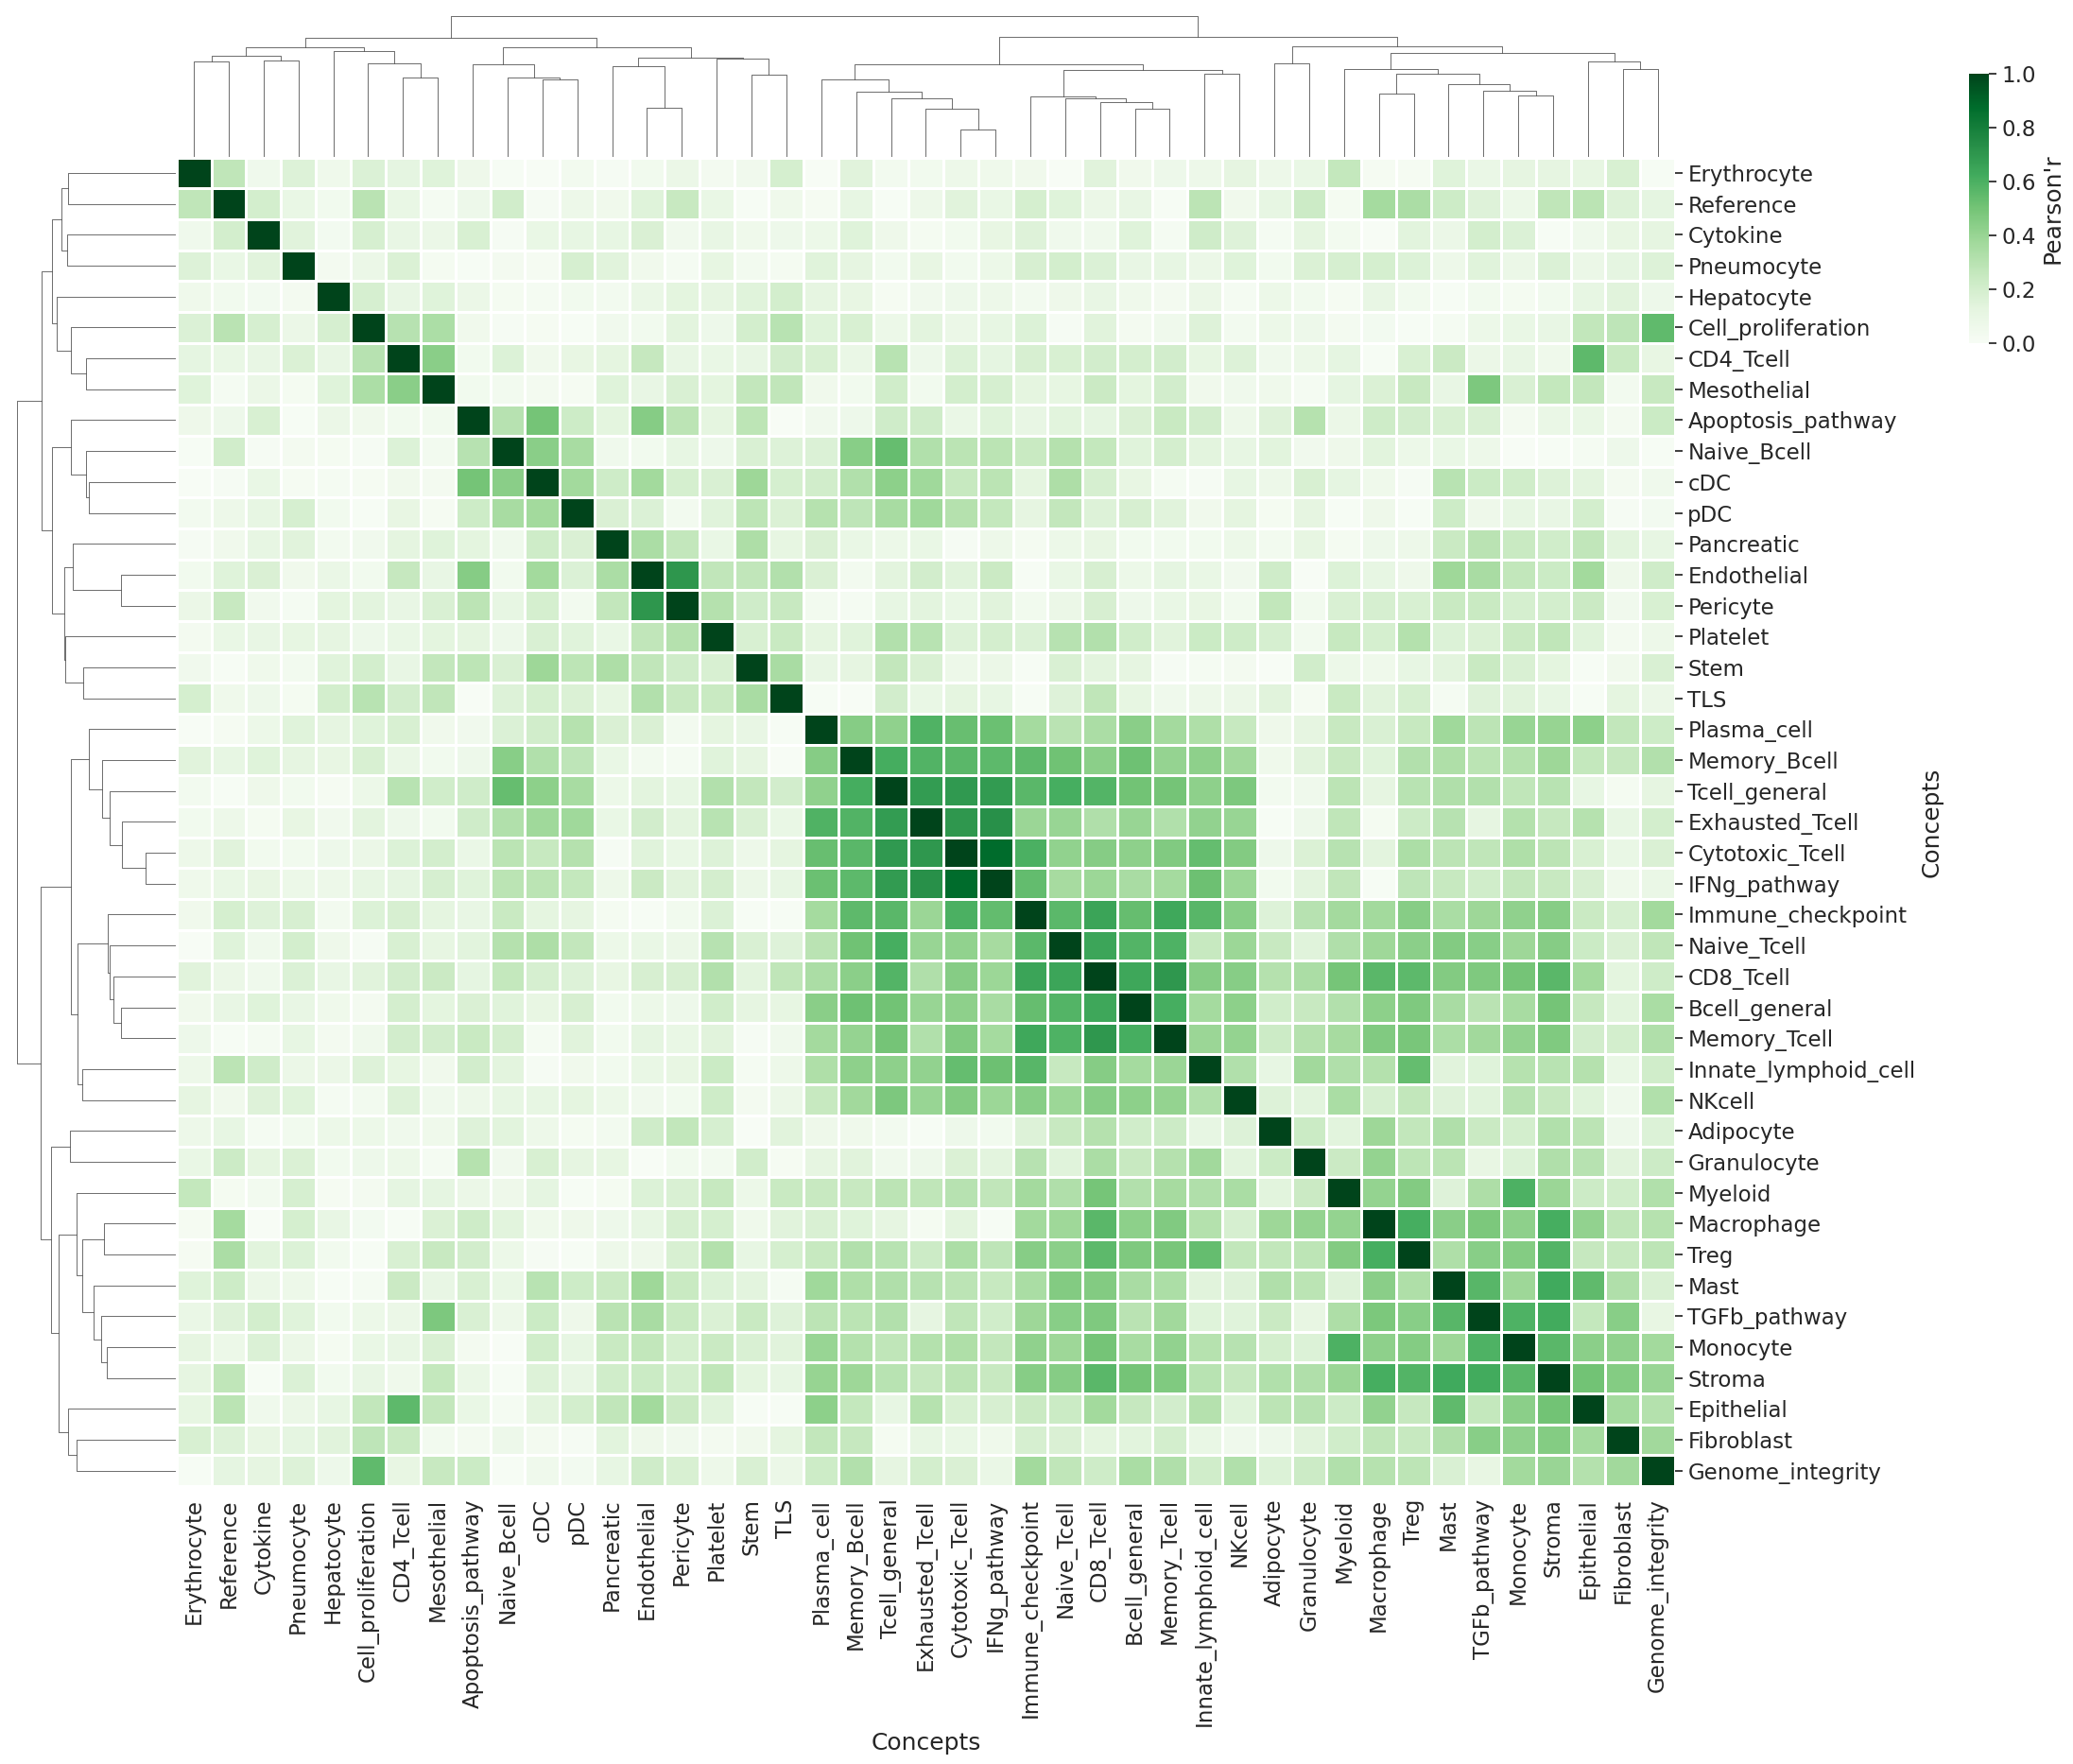

In [127]:
dfcs = pd.read_csv('../01_extract_readout/ITRP/02_readouts_celltype.csv', index_col=0)
dfcs = dfcs[dfcs.columns.difference(['CANCER'])]
data_corr = dfcs.corr().abs()
data_corr.columns.name = 'Concepts'
data_corr.index.name = 'Concepts'
g = sns.clustermap(data_corr,   cmap="Greens",
                   dendrogram_ratio=0.1,  vmin=0, vmax=1,
                   cbar_pos=(1, .8, .01, .15), cbar_kws = {'label':"Pearson'r"},
                   linewidths=.75, figsize=(21, 19))

# g.savefig('itrp_concept_score_sim2.svg')